In [6]:
from SPCCT_4D import Sample, Timepoint, Viewer, vesselDiameter

# Calling the bunny army
#s1 = Sample("1")
#s2 = Sample("2")
#s3 = Sample("3")
#s4 = Sample("4")
s5 = Sample("5")
#s6 = Sample("6")

#s7 = Sample("7")
#s8 = Sample("8") 
#s9 = Sample("9")
#s10 = Sample("10")

# Dotarem data (HU)
#d1 = Sample("dotarem1")
#d2 = Sample("dotarem2")
#d3 = Sample("dotarem3")
#d4 = Sample("dotarem4")
#d5 = Sample("dotarem5")
#d6 = Sample("dotarem6")

Available directories:
0: 2021_01_20.4511.400.2023_09_30.Rabbit_Aguix_4511_b00000
1: 2021_01_20.4511.500.2023_09_30.Rabbit_Aguix_4511_b00001
2: 2021_01_20.4511.600.2023_09_30.Rabbit_Aguix_4511_b00002
3: 2021_01_20.4511.700.2023_09_30.Rabbit_Aguix_4511_b00003
Conventional file 1 total DICOM files found: 480


KeyboardInterrupt: 

In [10]:
# Look at dicom metadata
import pydicom
file_path = "d://copyRaw//Rabbit_AGUIX_5//2021_01_27.4549.600.2024_03_25.AGUIX_Rabbit_26684_a00003//Conventional//dcm//0294.dcm"

#file_path = "D://copyRaw//Rabbit_AGUIX_dotarem1//2021_01_18.4500.500.2021_01_22.RABJAN00017//Conventional//dcm//0240.dcm"
medical_image = pydicom.read_file(file_path)
print(medical_image)

#print(.acquisition[1].kedge)

ValueError: embedded null character

Available directories:
0: 2021_01_27.4551.300.2024_03_18.AGUIX_Rabbit_10674_a00000
1: 2021_01_27.4551.400.2024_03_18.AGUIX_Rabbit_10674_a00001
2: 2021_01_27.4551.500.2024_03_18.AGUIX_Rabbit_10674_a00002
3: 2021_01_27.4551.600.2024_03_18.AGUIX_Rabbit_10674_a00003
4: 2021_01_27.4551.700.2024_03_18.AGUIX_Rabbit_10674_a00004
Conventional file 1 total DICOM files found: 480
Spectral/k_gadolinium file 1 total DICOM files found: 480
Conventional file 2 total DICOM files found: 480
Spectral/k_gadolinium file 2 total DICOM files found: 480
Conventional file 3 total DICOM files found: 480
Spectral/k_gadolinium file 3 total DICOM files found: 480
Conventional file 4 total DICOM files found: 480
Spectral/k_gadolinium file 4 total DICOM files found: 480
Conventional file 5 total DICOM files found: 480
Spectral/k_gadolinium file 5 total DICOM files found: 480
9.160000000000004
0.0


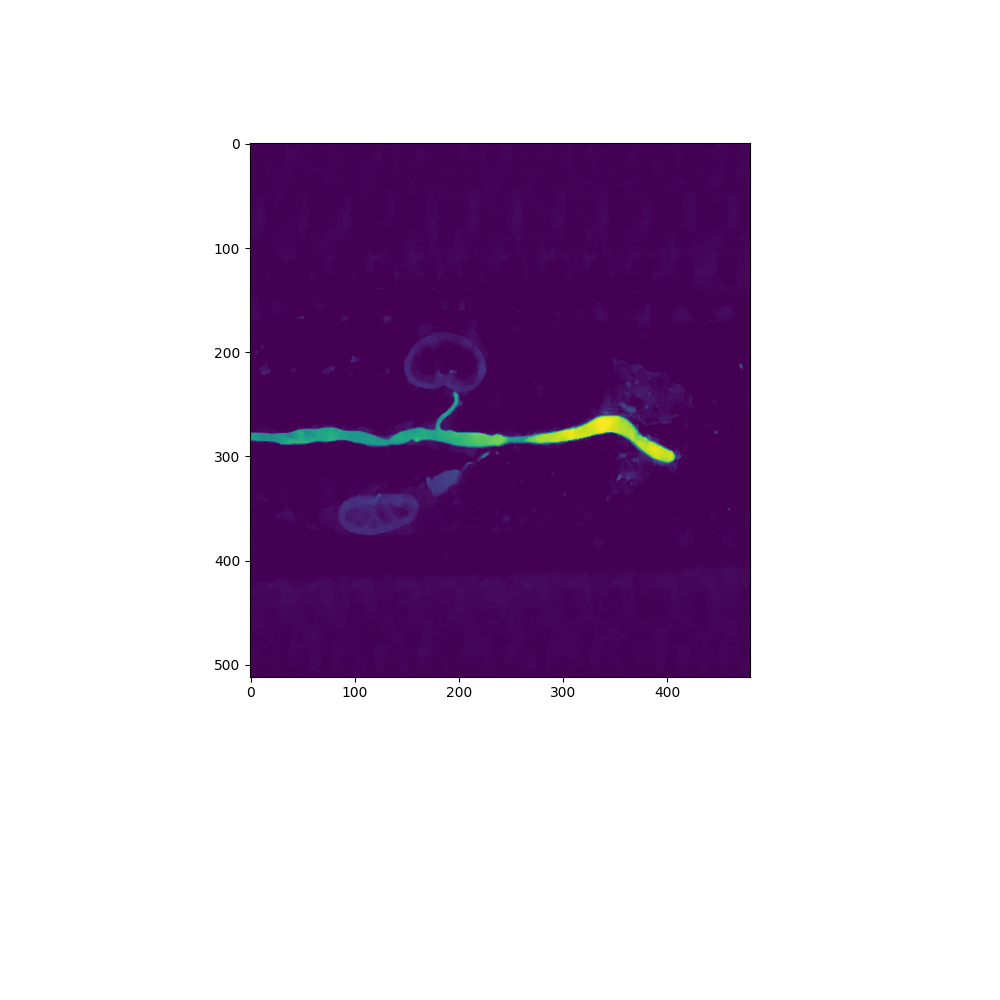

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
viewS4 = Sample("6")
plt.clf()
plt.imshow(viewS4.acquisition[0].kedge[279,:,:])
print(np.max(viewS4.acquisition[0].kedge[279,:,:]))
print(np.min(viewS4.acquisition[0].kedge[279,:,:]))
#old_array = viewS4.acquisition[0].conventional
#plt.imshow(old_array[250,:,:])
plt.show()

In [16]:
from skimage import morphology as MM
from SPCCT_4D import Sample, Timepoint, Viewer, vesselDiameter
import pandas as pd
import numpy as np
import nrrd

def makeItEasy(slices, sample, mask):
    readdata, header = nrrd.read(mask)
    mask_data = np.swapaxes(readdata, 0, 1)

    if slices is None:
        slices = 240  # Default slice count

    # Determine the presence of the mask
    mask_presence = np.any(mask_data == 1, axis=(0, 1))
    first_presence = np.argmax(mask_presence)  # Index of first presence
    print(f"First presence in slice: {first_presence}")
    last_presence = len(mask_presence) - 1 - np.argmax(mask_presence[::-1])  # Last index where there's data
    print(f"Last presence in slice:{last_presence}")
    # Ensure that you do not exceed the number of available slices
    end_slice = min(first_presence + slices, mask_data.shape[2])
    start_slice = first_presence  # Start from the first detected mask presence

    # Adjust mask_data and conventional to the calculated slice range
    mask_data = mask_data[:, :, start_slice:end_slice]

    washer_disk = np.zeros_like(mask_data, dtype=bool)
    for i in range(mask_data.shape[2]):
        washer_disk[:, :, i] = MM.dilation(mask_data[:, :, i], MM.disk(3)) & ~mask_data[:, :, i]

    measurements = []

    for i in range(len(sample.acquisition)):
        conventional = sample.acquisition[i].kedge

        # Ensure conventional data matches the slice range of mask_data
        if conventional.shape[2] > start_slice + (end_slice - start_slice):
            conventional = conventional[:, :, start_slice:end_slice]

        indices = np.where(mask_data == 1)
        signal_HU = np.mean(conventional[indices])
        std_hu = np.std(conventional[indices])
        noise_indices = np.where(washer_disk == 1)
        noise_HU = np.mean(conventional[noise_indices])
        std_noise = np.std(conventional[noise_indices])

        pixel_volume = 0.5 * 0.5 * 0.5  # Voxel volume in mm³
        volume = np.sum(mask_data == 1) * pixel_volume
        normalized_signal = signal_HU / volume

        noise_volume = np.sum(washer_disk == 1) * pixel_volume
        normalized_noise = noise_HU / noise_volume

        cnr_hu = (signal_HU - noise_HU) / np.std(conventional[noise_indices])

        measurements.append({
            "Signal_HU": signal_HU, "STD_HU": std_hu,
            "Volume": volume,
            "Normalized_Signal": normalized_signal,
            "Noise_HU": noise_HU,
            "STD_Noise": std_noise,
            "Noise_Volume": noise_volume,
            "Normalized_Noise": normalized_noise,
            "CNR_HU": cnr_hu
        })

    data = pd.DataFrame(measurements)
    print(data)
    data.to_csv("dataframe.csv", index=False)

# Parameters
slices = 240
mask = "D:/3d_masks/aorta_s6.seg.nrrd"
sample = Sample("6")
makeItEasy(slices, sample, mask)



Available directories:
0: 2021_01_27.4551.300.2024_03_18.AGUIX_Rabbit_10674_a00000
1: 2021_01_27.4551.400.2024_03_18.AGUIX_Rabbit_10674_a00001
2: 2021_01_27.4551.500.2024_03_18.AGUIX_Rabbit_10674_a00002
3: 2021_01_27.4551.600.2024_03_18.AGUIX_Rabbit_10674_a00003
4: 2021_01_27.4551.700.2024_03_18.AGUIX_Rabbit_10674_a00004
Conventional file 1 total DICOM files found: 480
Spectral/k_gadolinium file 1 total DICOM files found: 480
Conventional file 2 total DICOM files found: 480
Spectral/k_gadolinium file 2 total DICOM files found: 480
Conventional file 3 total DICOM files found: 480
Spectral/k_gadolinium file 3 total DICOM files found: 480
Conventional file 4 total DICOM files found: 480
Spectral/k_gadolinium file 4 total DICOM files found: 480
Conventional file 5 total DICOM files found: 480
Spectral/k_gadolinium file 5 total DICOM files found: 480
First presence in slice: 59
Last presence in slice:453
   Signal_HU    STD_HU    Volume  Normalized_Signal  Noise_HU  STD_Noise  \
0   3.66393

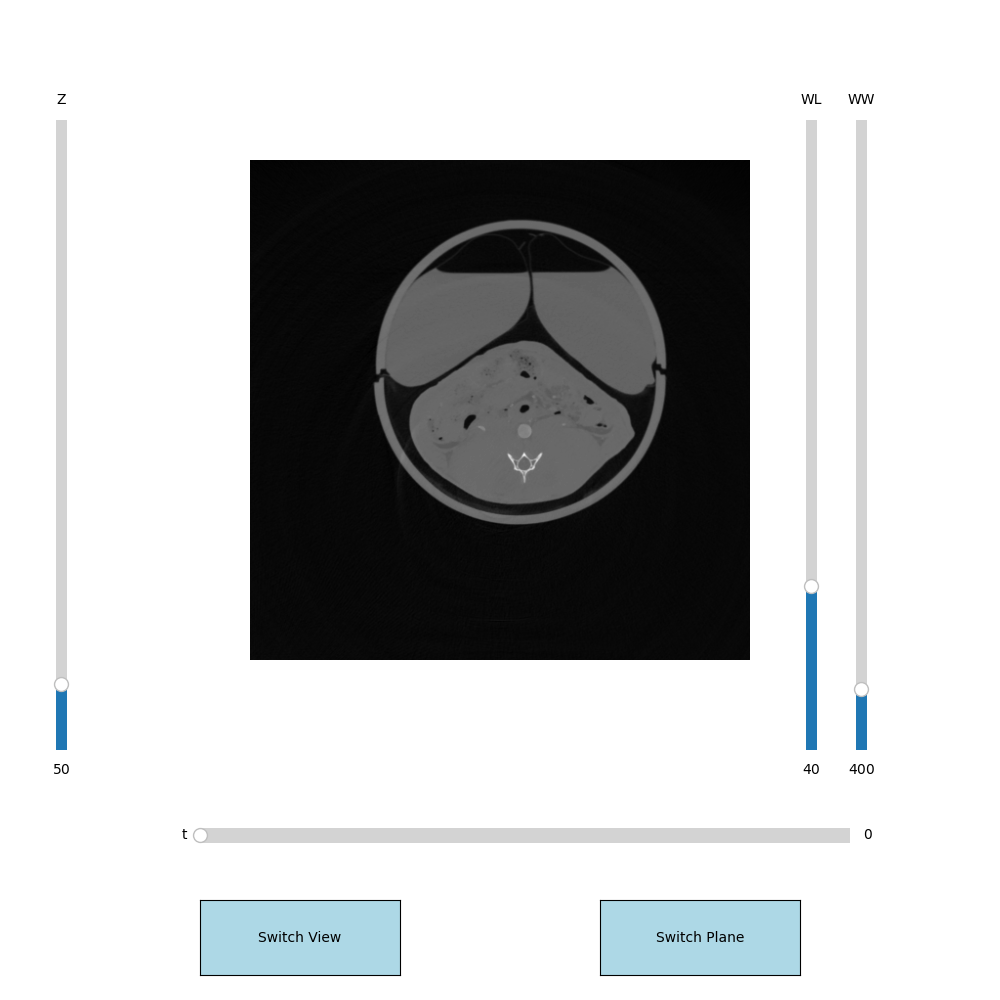

    Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0  -83.157895  -94.880952  1.290405      0.065263     0.068571  -0.043323
1  111.842105  121.904762 -0.865627      0.882105     0.867619   0.232418
2  131.947368  142.047619 -0.683258      1.218947     1.287143  -0.210202
3  174.894737  190.642857 -0.533170      1.923158     2.000952  -0.182775
4  130.473684  143.785714 -0.470140      1.274737     1.365714  -0.248880


c:\Users\Chris\OneDrive\2023\BME_M2\STAGE\Thesis\Scripts_and_venv\internship_M2\SPCCT_4D.py:471: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


In [18]:
%matplotlib widget
from SPCCT_4D import VesselAnalyzer
VesselAnalyzer(sample)

(512, 512, 480)


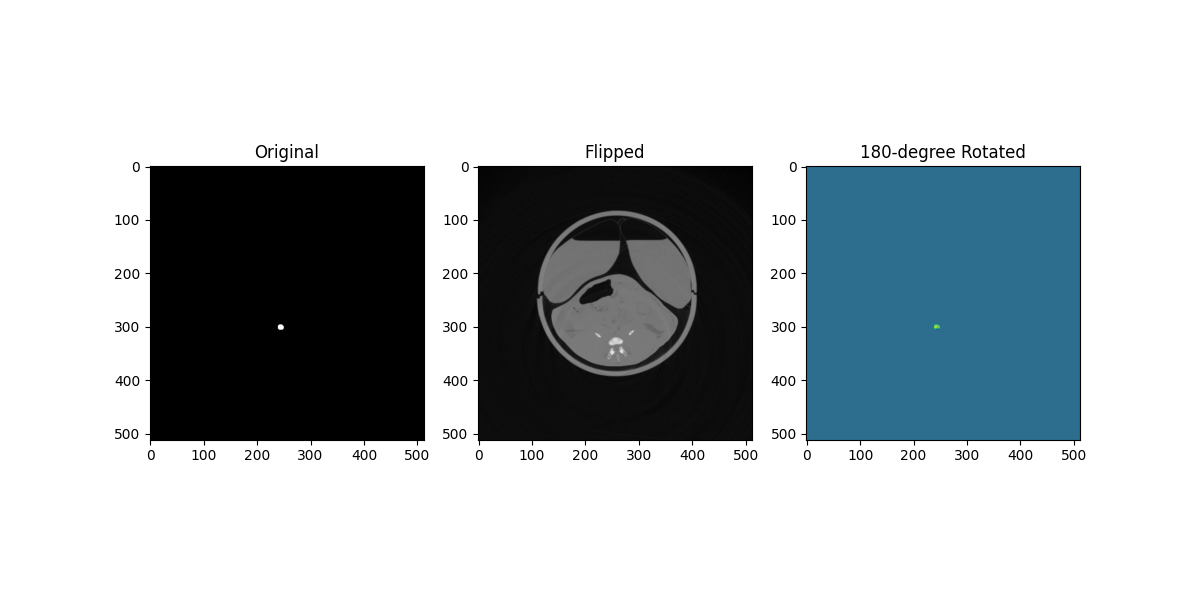

52.026804170547216
47.81510407881384


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd

# Load your data
readdata, header = nrrd.read("D:/3d_masks/ivc_s2_t1.seg.nrrd")
sampview = s2
# Flip both the x and y axes to mimic a 180-degree rotation about the z-axis
flipped_data = np.swapaxes(readdata, 0, 1)
print(flipped_data.shape)

# Plot to compare
plt.figure(figsize=(12, 6))
n = 209
plt.subplot(1, 3, 1)
plt.imshow(flipped_data[:, :, n], cmap='gray')  # Change slice index as necessary
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(sampview.acquisition[2].conventional[:, :, n], cmap='gray')
plt.title("Flipped")

indices = np.where(flipped_data == 1)
#indices = indices[240:]

plt.subplot(1, 3, 3)
plt.imshow(flipped_data[:,:,n]*sampview.acquisition[0].conventional[:, :, n])
plt.title("180-degree Rotated")

plt.show()
    

print(np.mean(sampview.acquisition[3].conventional[indices]))
print(np.std(sampview.acquisition[3].conventional[indices]))


Available directories:
0: 2021_01_29.4572.300.2024_03_25.AGUIX_Rabbit_26361_a00000
1: 2021_01_29.4572.400.2024_03_25.AGUIX_Rabbit_26361_a00001
2: 2021_01_29.4572.500.2024_03_25.AGUIX_Rabbit_26361_a00002
3: 2021_01_29.4572.600.2024_03_25.AGUIX_Rabbit_26361_a00003
4: 2021_01_29.4572.700.2024_03_25.AGUIX_Rabbit_26361_a00004
Conventional file 1 total DICOM files found: 480
Spectral/k_gadolinium file 1 total DICOM files found: 480
Conventional file 2 total DICOM files found: 480
Spectral/k_gadolinium file 2 total DICOM files found: 480
Conventional file 3 total DICOM files found: 480
Spectral/k_gadolinium file 3 total DICOM files found: 480
Conventional file 4 total DICOM files found: 480
Spectral/k_gadolinium file 4 total DICOM files found: 480
Conventional file 5 total DICOM files found: 480
Spectral/k_gadolinium file 5 total DICOM files found: 480


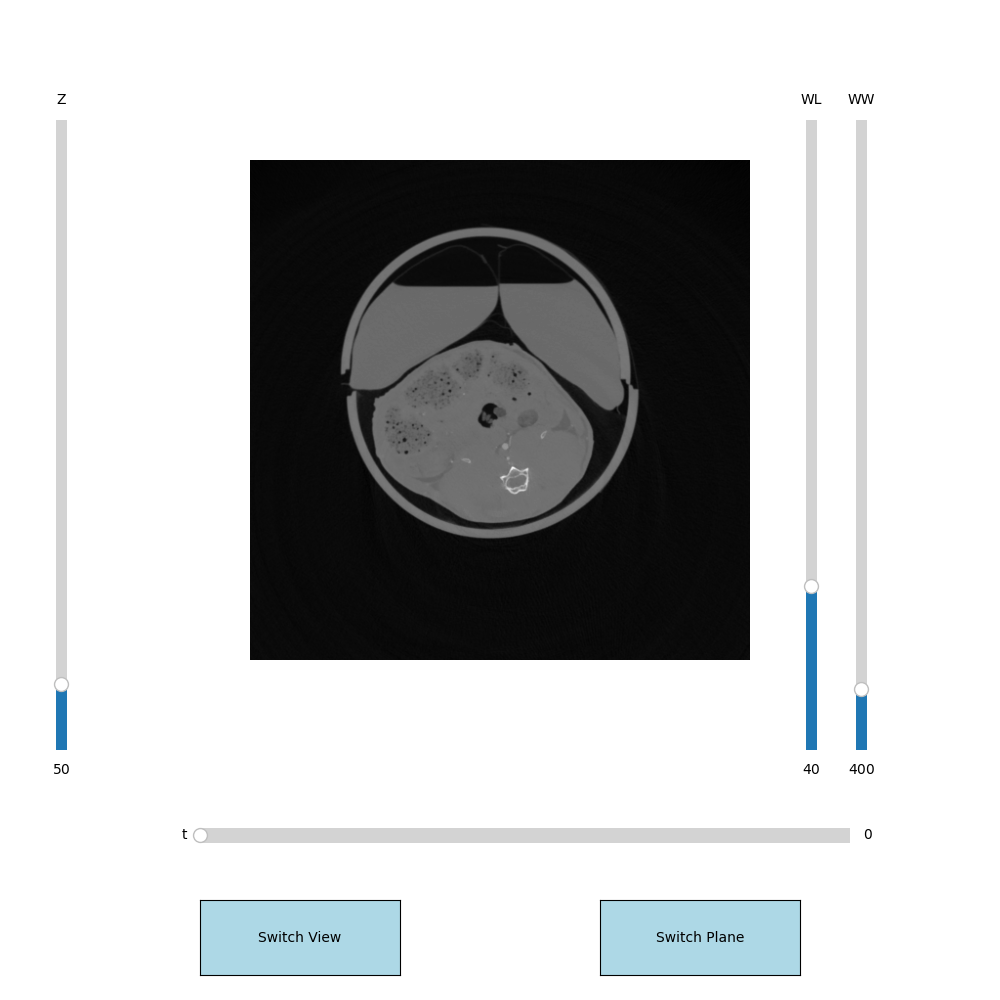

   Signal_HU   Noise_HU  Signal_std    CNR_HU  Signal_Kedge  Noise_Kedge  \
0 -90.631579 -89.311111    7.392817 -0.197989      0.064211     0.072889   
1 -77.842105 -54.311111   23.104484 -0.431593      0.117895     0.087556   
2 -88.263158 -49.088889   20.057397 -0.697415      0.012632     0.010222   
3 -74.473684 -38.866667   24.055568 -0.774069      0.122105     0.134667   
4 -79.842105 -52.044444   31.699681 -0.513315      0.030526     0.027556   

   Kedge_std  CNR_Kedge  
0   0.019006  -0.418784  
1   0.052272   0.408491  
2   0.016171   0.175329  
3   0.041496  -0.131228  
4   0.027043   0.072178  


c:\Users\Chris\OneDrive\2023\BME_M2\STAGE\Thesis\Scripts_and_venv\internship_M2\SPCCT_4D.py:471: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


In [11]:
%matplotlib widget
from SPCCT_4D import Sample, Timepoint, Viewer,VesselAnalyzer, vesselDiameter
echantillon = Sample("10")
VesselAnalyzer(echantillon)

In [64]:
#Viewer(s2)
%matplotlib widget
import nrrd
import numpy as np
import scipy.ndimage as ndi
ready3d = Sample("dotarem1") 
readdata, header = nrrd.read("D:/3d_masks/ivc_d1.seg.nrrd")
readdata = np.swapaxes(readdata, 0, 1)

presence = np.any(readdata == 1, axis=(0, 1))
readdata = readdata[:, :, presence]  # Filter mask data to only include relevant slices
print("Mask data shape after filtering:", readdata.shape)

for i in range(0,5):
    if ready3d.acquisition[i].conventional.shape[2] > presence.shape[0]:
        # Ensure the acquisition data has enough slices to match the mask data slice count
        ready3d.acquisition[i].conventional = ready3d.acquisition[i].conventional[:, :, presence]
        ready3d.acquisition[i].kedge = ready3d.acquisition[i].kedge[:, :, presence]
        
    ready3d.acquisition[i].conventional = readdata*ready3d.acquisition[i].conventional[:,:,presence]
    ready3d.acquisition[i].kedge = readdata*ready3d.acquisition[i].kedge[:,:,presence]
    # Apply the same slicing to the image acquisition data

#ready3d.acquisition[1].conventional = readdata*ready3d.acquisition[1].conventional

diameters = 2*np.max(ndi.distance_transform_edt(readdata), axis = (0,1))
indices = np.where(ndi.distance_transform_edt(diameters) > 0.5)
diameters = diameters[indices]
print(diameters.shape)
diameters = diameters[0:240]
print(diameters[0])
print(diameters[239])
print(np.mean(diameters))
print(np.std(diameters))
print(max(diameters))
print(min(diameters))
Viewer(ready3d)

Available directories:
0: 2021_01_18.4500.300.2021_01_22.RABJAN00015
1: 2021_01_18.4500.400.2021_01_22.RABJAN00016
2: 2021_01_18.4500.500.2021_01_22.RABJAN00017
3: 2021_01_18.4500.600.2021_01_22.RABJAN00018
4: 2021_01_18.4500.700.2021_01_22.RABJAN00019
Conventional file 1 total DICOM files found: 480
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem1\2021_01_18.4500.300.2021_01_22.RABJAN00015\Spectral/k_gadolinium.
Conventional file 2 total DICOM files found: 240
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem1\2021_01_18.4500.400.2021_01_22.RABJAN00016\Spectral/k_gadolinium.
Conventional file 3 total DICOM files found: 240
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem1\2021_01_18.4500.500.2021_01_22.RABJAN00017\Spectral/k_gadolinium.
Conventional file 4 total DICOM files found: 240
No DICOM files found in D:\copyRaw\Rabbit_AGUIX_dotarem1\2021_01_18.4500.600.2021_01_22.RABJAN00018\Spectral/k_gadolinium.
Conventional file 5 total DICOM files found: 240
No DICOM f

IndexError: boolean index did not match indexed array along dimension 2; dimension is 480 but corresponding boolean dimension is 240

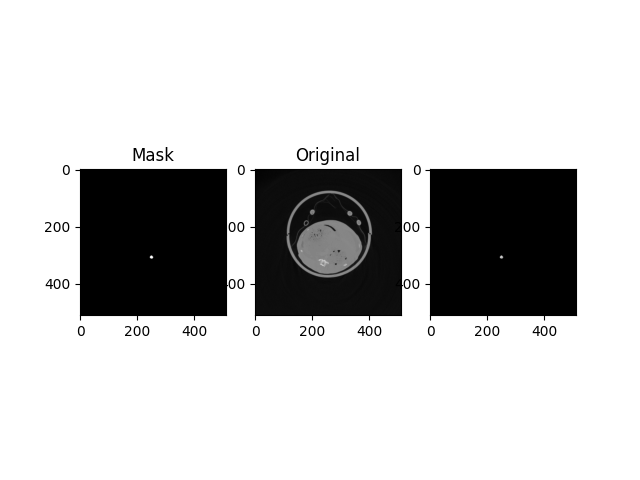

In [3]:
from SPCCT_4D import vesselDiameter
%matplotlib widget
import matplotlib.pyplot as plt
import nrrd
import numpy as np
#s5 = Sample("5")
samp = s1
readdata, header = nrrd.read("D:/3d_masks/aorta_s1.seg.nrrd")
readdata = np.swapaxes(readdata, 0 , 1)
# Clear the current figure (if any) to start fresh
plt.clf()
# Create a subplot for the mask
plt.subplot(1, 3, 1)
plt.imshow(readdata[:, :, 450], cmap='gray')  # Assuming the slice index 250 is correct
plt.title("Mask")

# Create a subplot for the original image
plt.subplot(1, 3, 2)
plt.imshow(s1.acquisition[1].conventional[:, :, 450], cmap='gray')  # Ensure the index is correctly aligned with your data
plt.title("Original")


plt.subplot(1,3,3)
plt.imshow(readdata[:, :, 450]*samp.acquisition[1].conventional[:, :, 450], cmap = 'gray')
# Show the plots
plt.show()
#plt.clf()
#samp.acquisition[1].conventional = readdata*s1.acquisition[1].conventional
#Viewer(samp)
#samp.acquisition[0].conventional[:,:,0:239] = samp.acquisition[0].conventional[:,:,240:479]
#samp.acquisition[0].conventional = samp.acquisition[0].conventional[:,:,0:239]

# Load previously made mask to evaluate quality
#vesselDiameter(samp, "Masks\\IVC_s4_292_t1.npy")
#vesselDiameter(samp, "Vessel_Masks\\SAA_d5_167.npy")
#vesselDiameter(samp, "Kidney_Masks\\r_cortex_d5_41.npy")

#vesselDiameter(samp, "D:/3d_masks/aorta_s1.seg.nrrd")


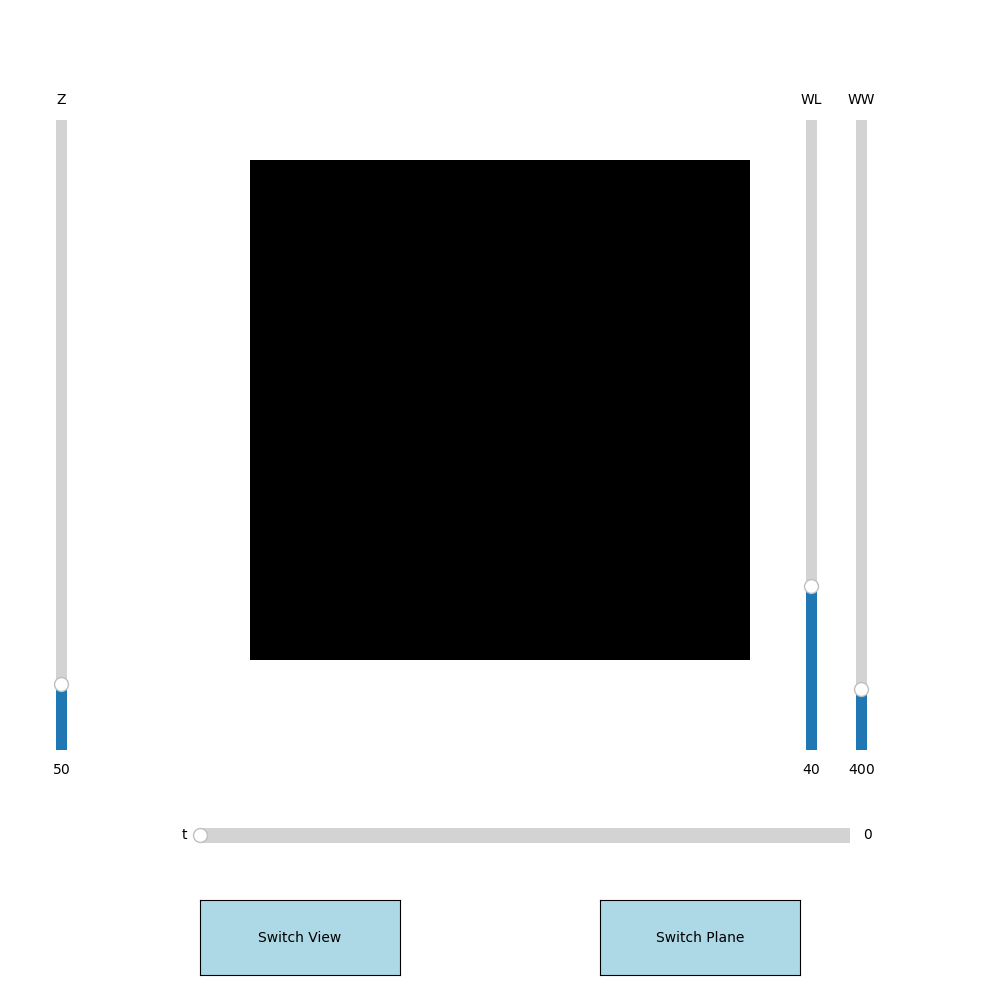

In [140]:
Viewer(image)

Maximum pixel value (HU):2061.470561051382
Minimum pixel value (HU):-1247.1274899339442
Maximum pixel value (mg/mL):14.620000000000005
Minimum pixel value (mg/mL):1.387068995956187e-31


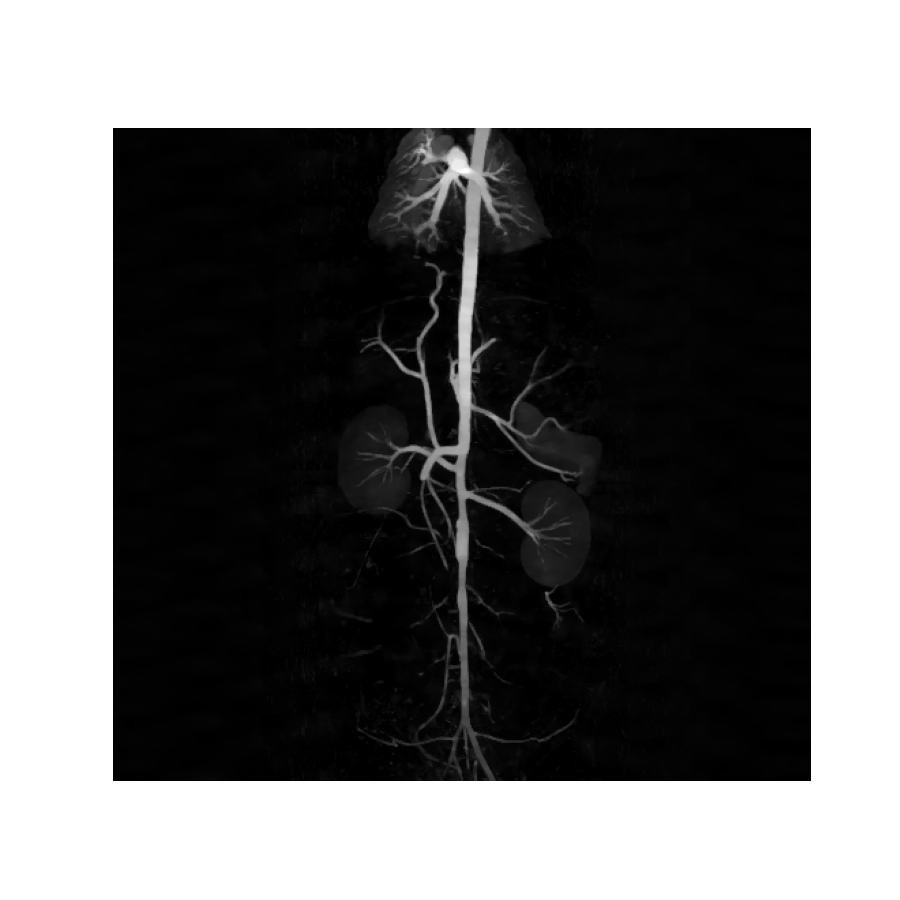

In [180]:
import SPCCT_4D  # Assuming this is your custom library
import scipy.ndimage as ndi  # You import but do not use this, consider removing if not needed
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

#Assuming Sample is a function or class that loads image data
#image = SPCCT_4D.Sample("2")

def apply_window(image, level, width):
    lower = level - (width / 2)
    upper = level + (width / 2)
    return np.clip(image, lower, upper)

plt.clf()
plt.figure(figsize=(9, 9))
# Maximum Intensity Projection (MIP)
#plt.subplot(1, 3, 1)

#axial = ndimage.rotate(image.acquisition[0].conventional, 45, axes = (0,1), cval = -100)

#np.any(axial == 0)

#doosy = axial[200:375, :, :]
#mip = np.max(apply_window(doosy, 225, 650), axis = 0)

print(f"Maximum pixel value (HU):{np.max(doosy)}")
print(f"Minimum pixel value (HU):{np.min(doosy)}")
#plt.imshow(np.rot90(mip), cmap="gray")

# Mean Intensity Projection
#plt.subplot(1, 3, 2)
thresh = image.acquisition[0].kedge > 0

kedge_mip = np.rot90(np.max(ndimage.rotate(image.acquisition[0].kedge[275:350,:,:]*thresh[275:350,:,:], 0, axes = (0,1), cval = 0), axis=0))
plt.imshow(kedge_mip, cmap="gray")

print(f"Maximum pixel value (mg/mL):{np.max(kedge_mip)}")
print(f"Minimum pixel value (mg/mL):{np.min(kedge_mip)}")
plt.axis("off")
plt.show()
plt.savefig("clean_image.pdf", bbox_inches='tight', pad_inches=0, format='pdf', dpi=300)

In [169]:
plt.subplot(1,2,1)
plt.imshow(np.max(image.acquisition[0].conventional[200:400, :,:], axis = 0), cmap = 'gray')

plt.subplot(1,2,2)
plt.imshow(np.max(image.acquisition[0].kedge[200:400, :,:], axis = 0), cmap = 'gray')

In [139]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import imageio

# Example data: Create a random 3D array to simulate a volume
data = image.acquisition[0].kedge
thresh = data < 16  # Dimensions [depth, height, width]
data = data*thresh
def normalize_image(image):
    image_min = np.min(image)
    image_max = np.max(image)
    # Normalize to [0, 1]
    normalized_image = (image - image_min) / (image_max - image_min)
    # Scale to [0, 255]
    scaled_image = (normalized_image * 255).astype(np.uint8)
    return scaled_image

def rotate_and_extract_mip(data, angle, start_depth, end_depth):
    # Rotate the volume around the Y-axis
    
    rotated = ndimage.rotate(data, angle, axes=(0, 1), reshape=False, mode='nearest', cval = 0)
    # Compute MIP over the specified depth range for a coronal slice
    mip = np.rot90(np.max(rotated[ start_depth:end_depth, :, :], axis=0))
    mip = normalize_image(mip)
    return mip

# Parameters for the rotation and MIP extraction
angles = np.linspace(0, 360, num=36)  # Generate 36 frames for a full rotation
start_depth = 250  # Start of the depth range for the MIP
end_depth = 350   # End of the depth range for the MIP

frames = []
for angle in angles:
    frame = rotate_and_extract_mip(data, angle, start_depth, end_depth)
    frames.append(frame)

# Optionally save as a GIF
imageio.mimsave('rotating_coronal_mip.gif', frames, duration=0.1)

# Show one of the frames as an example
plt.imshow(frames[18], cmap='gray')  # Show the frame at 180 degrees
plt.title('Coronal MIP at 180°')
plt.axis('off')
plt.show()



KeyboardInterrupt: 

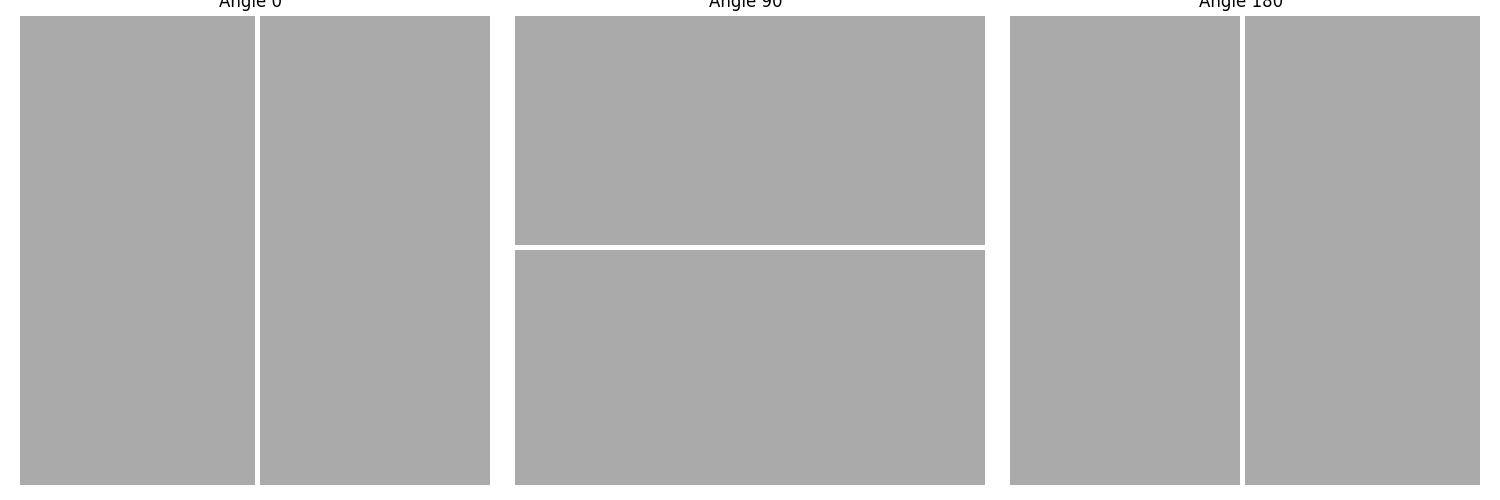

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

# Create a diagnostic volume
data = np.zeros((100, 100, 100))
data[50, :, :] = 1  # Mark the middle slice along depth (Z-axis)
data[:, 50, :] = 2  # Mark the middle slice along height (Y-axis)
data[:, :, 50] = 3  # Mark the middle slice along width (X-axis)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
angles = [0, 90, 180]

# Rotate around what we consider the Y-axis
for i, angle in enumerate(angles):
    rotated = ndimage.rotate(data, angle, axes=(0, 2), reshape=False)
    # Displaying the slice along the Y-axis to view rotation effects on X and Z
    axs[i].imshow(rotated[:, 50, :], cmap='gray', vmin=0, vmax=3)
    axs[i].set_title(f'Angle {angle}°')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


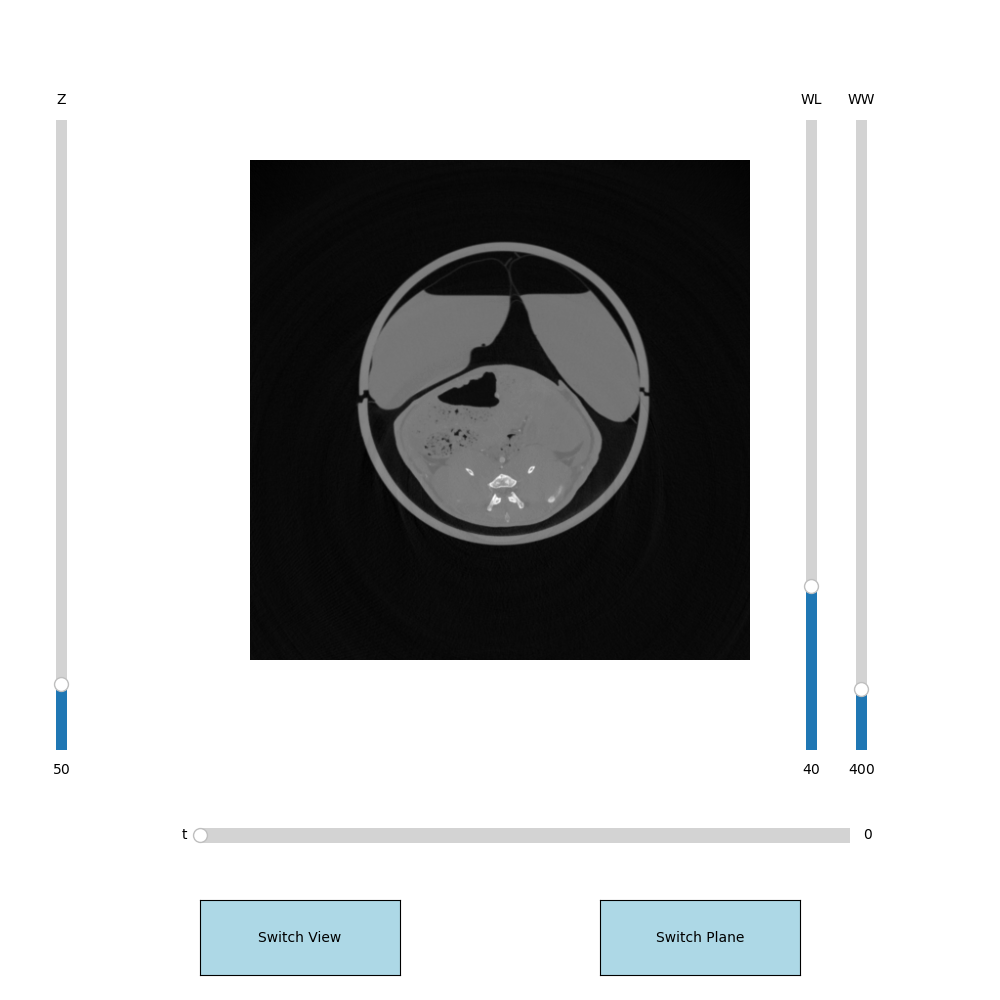

Processing the selection...
275
    Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0  526.600000  433.962441  0.499447      8.118333     6.701221   0.694570
1   35.000000  -73.676056  0.434113      0.000000     0.013803  -0.226383
2    6.133333 -109.286385  0.422331      0.002333     0.018122  -0.196607
3   22.816667 -108.624413  0.453326      0.000000     0.000188  -0.068680
4  -33.316667 -214.882629  0.475843      0.010333     0.001784   0.503862


c:\Users\Chris\OneDrive\2023\BME_M2\STAGE\Thesis\Scripts_and_venv\internship_M2\SPCCT_4D.py:335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


In [178]:
vesselDiameter(image)